In [7]:
import pandas as pd
import geopandas as gpd
import pygmt
import numpy as np
import requests
import obspy

In [8]:
# Choose fonts: to learn more, search gmt.conf on pygmt webpage
pygmt.config(FONT='10p,Times-Roman,black')
pygmt.config(FONT_LABEL='10p,Times-Roman,black')
pygmt.config(FONT_TITLE='10p,Times-Roman,black')
pygmt.config(MAP_TITLE_OFFSET='6.0p')
pygmt.config(FORMAT_GEO_MAP="ddd")

# Set Regional Map dimensions
west = -135.0
east = -105.0
south = 35.0
north = 53.0
region_data = np.array([west, east, south, north])

# Get center position and two latitude locations to define regional projection
clon = np.floor(region_data[0:2].mean())
clat = np.floor(region_data[2:4].mean())
lat1 = np.floor(0.5*(north - clat) + clat )
lat2 = np.floor(clat - 0.5*(clat - south) )
mapwidth = 5.0 # inches, sets size of figure on page
#f-string python syntax
proj1 = f'B{clon}/{clat}/{lat1}/{lat2}/{mapwidth}i'
print(proj1)

B-120.0/44.0/48.0/39.0/5.0i


In [9]:
params = {
    "request": "COLLECTED",
    "req_agcy": "ISC-EHB",
    "out_format": "QuakeML",
    "ctr_lat": "",
    "ctr_lon": "",
    "radius": "",
    "max_dist_units": "deg",
    "searchshape": "RECT",
    "top_lat": north,
    "bot_lat": south,
    "left_lon": west,
    "right_lon": east,
    "srn": "",
    "grn": "",
    "start_year": 1964,
    "start_month": 1,
    "start_day": 1,
    "start_time": "00:00:00",
    "end_year": 2021,
    "end_month": 12,
    "end_day": 31,
    "end_time": "00:00:00",
    "min_dep": "",
    "max_dep": "",
    "min_mag": 0.0,
    "max_mag": "",
    "req_mag_type": "Any",
    "req_mag_agcy": "Any",
    "min_def": "",
    "max_def": "",
    "prime_only": "on",
    "include_magnitudes": "on",
    "table_owner": "iscehb"
}

url = "http://www.isc.ac.uk/cgi-bin/web-db-run"
response = requests.get(url, params=params)

with open("ISC-EHB.xml", "wb") as file:
    file.write(response.content)

In [10]:
# read with obspy
iscehb = obspy.read_events("ISC-EHB.xml")

# write to csv
iscehb.write("ISC-EHB.shp", format="SHAPEFILE")

In [11]:
# read with geopandas
iscehb_gdf = gpd.read_file("ISC-EHB.shp")

iscehb_gdf.head()

,EventID,OriginID,MagID,Date,OriginTime,FirstPick,Longitude,Latitude,Depth,MinHorUncM,MaxHorUncM,MaxHorAzi,OriUncDesc,Magnitude,geometry
0,smi:ISCEHB/evid=615781082,smi:ISCEHB/origid=612105338,smi:ISCEHB/magid=300791631,1964-03-31,-1.815803e+08,NaN,-130.306,50.732,10.0,5100.0,10100.0,47.0,uncertainty ellipse,6.02,POINT (-130.306 50.732)
1,smi:ISCEHB/evid=615781533,smi:ISCEHB/origid=612105789,smi:ISCEHB/magid=300696978,1964-07-02,-1.735153e+08,NaN,-128.713,47.748,15.0,6900.0,14500.0,51.0,uncertainty ellipse,4.90,POINT (-128.713 47.748)
2,smi:ISCEHB/evid=615781909,smi:ISCEHB/origid=612106165,smi:ISCEHB/magid=300793662,1964-10-21,-1.639597e+08,NaN,-111.553,44.859,10.0,6700.0,7700.0,58.0,uncertainty ellipse,5.01,POINT (-111.553 44.859)
3,smi:ISCEHB/evid=615784124,smi:ISCEHB/origid=612108380,smi:ISCEHB/magid=300795491,1965-03-03,-1.524268e+08,NaN,-116.037,37.064,0.7,NaN,NaN,NaN,None,5.36,POINT (-116.037 37.064)
4,smi:ISCEHB/evid=615784221,smi:ISCEHB/origid=612108477,smi:ISCEHB/magid=300795812,1965-03-26,-1.504528e+08,NaN,-116.043,37.148,0.5,NaN,NaN,NaN,None,5.10,POINT (-116.043 37.148)


In [12]:
# Get topography data for basemap
topogrid = pygmt.datasets.load_earth_relief(region=region_data,
                                            resolution="01m",
                                            registration="pixel")
shade = pygmt.grdgradient(grid=topogrid, azimuth=300)
colormap = pygmt.grd2cpt(grid=topogrid,cmap="gray")

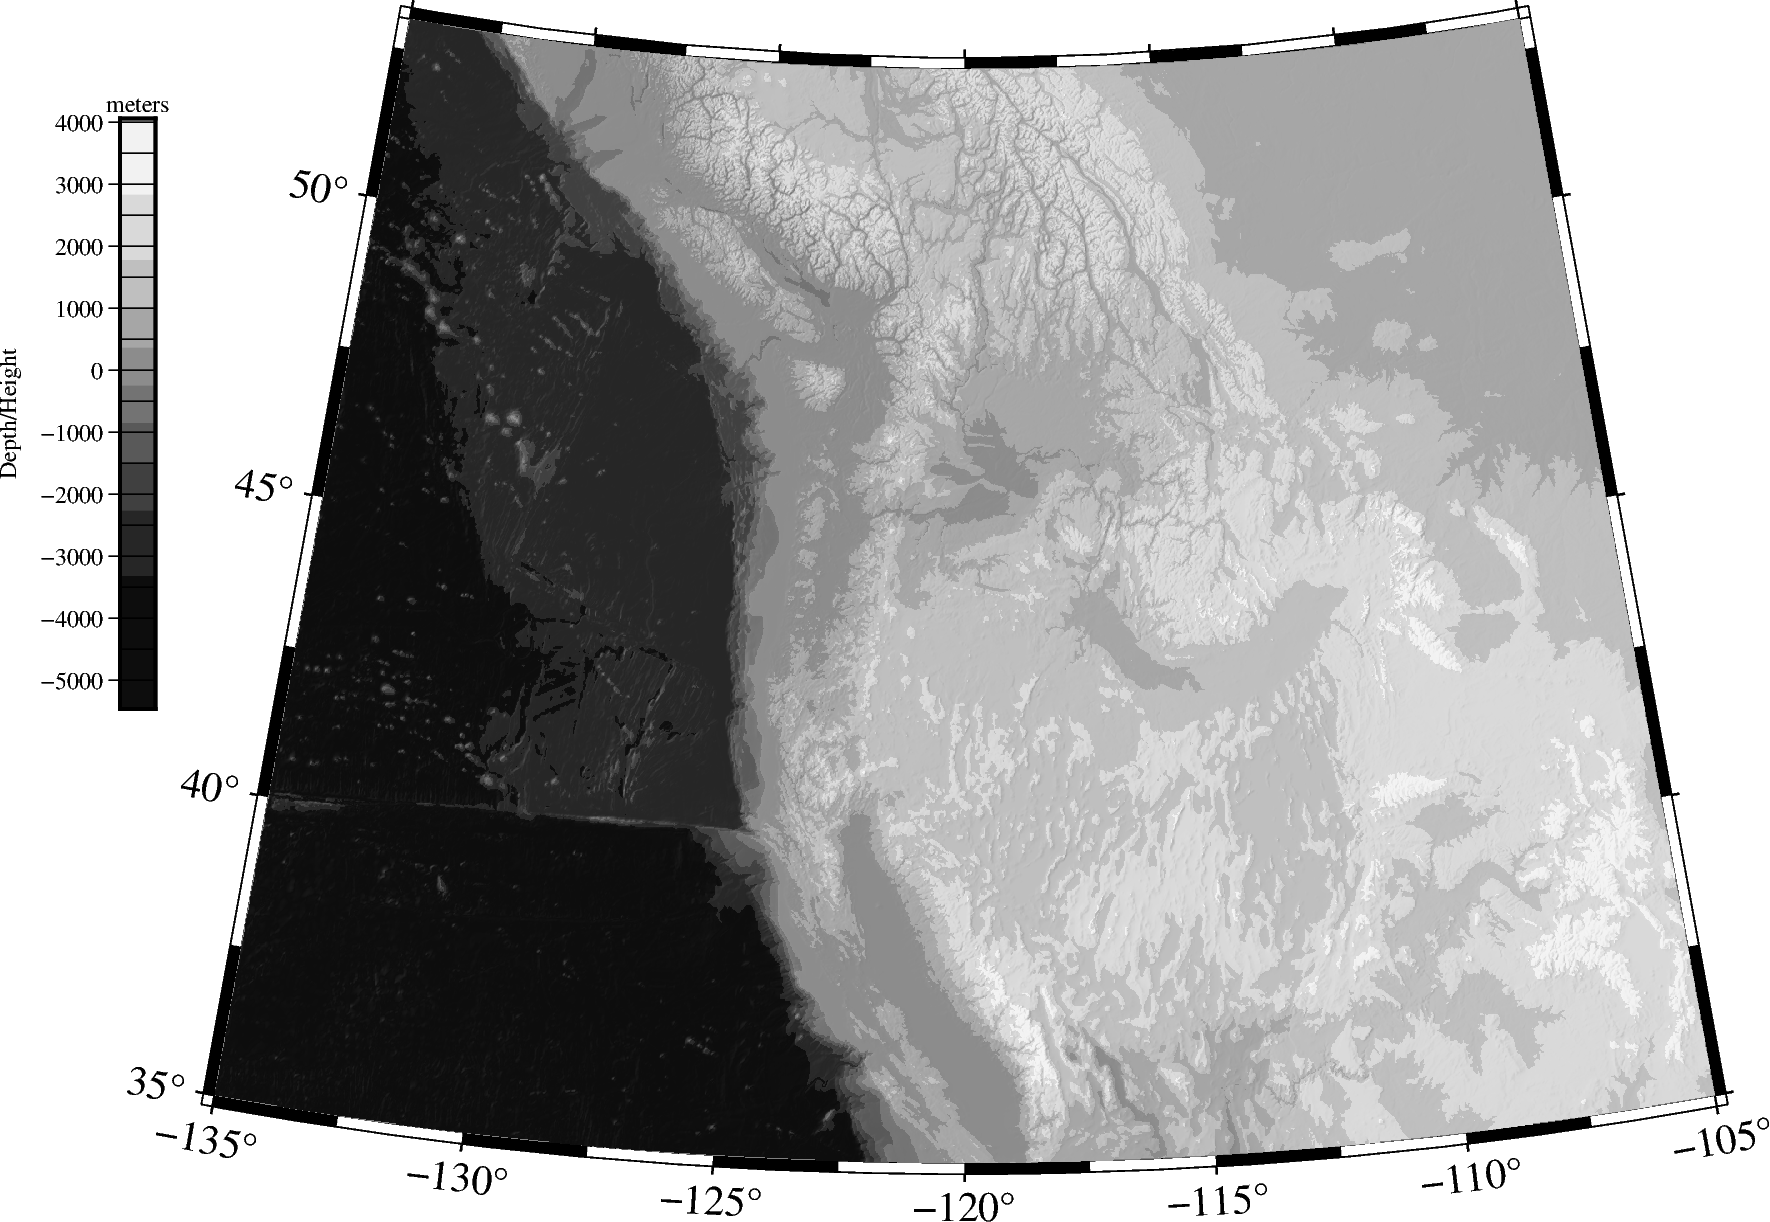

In [13]:
# Start figure
fig = pygmt.Figure()
fig.basemap(region=region_data, projection=proj1,
            frame=["a5f2.5", f'WSne'])
fig.grdimage(grid=topogrid,shading=shade,cmap=colormap)
fig.colorbar(position="JML+o0.5c/1.5c+w5c/0.3c", box=False,
             frame=["a1000g500","x+lDepth/Height", "y+lmeters"])

fig.show()

0.0 100.0


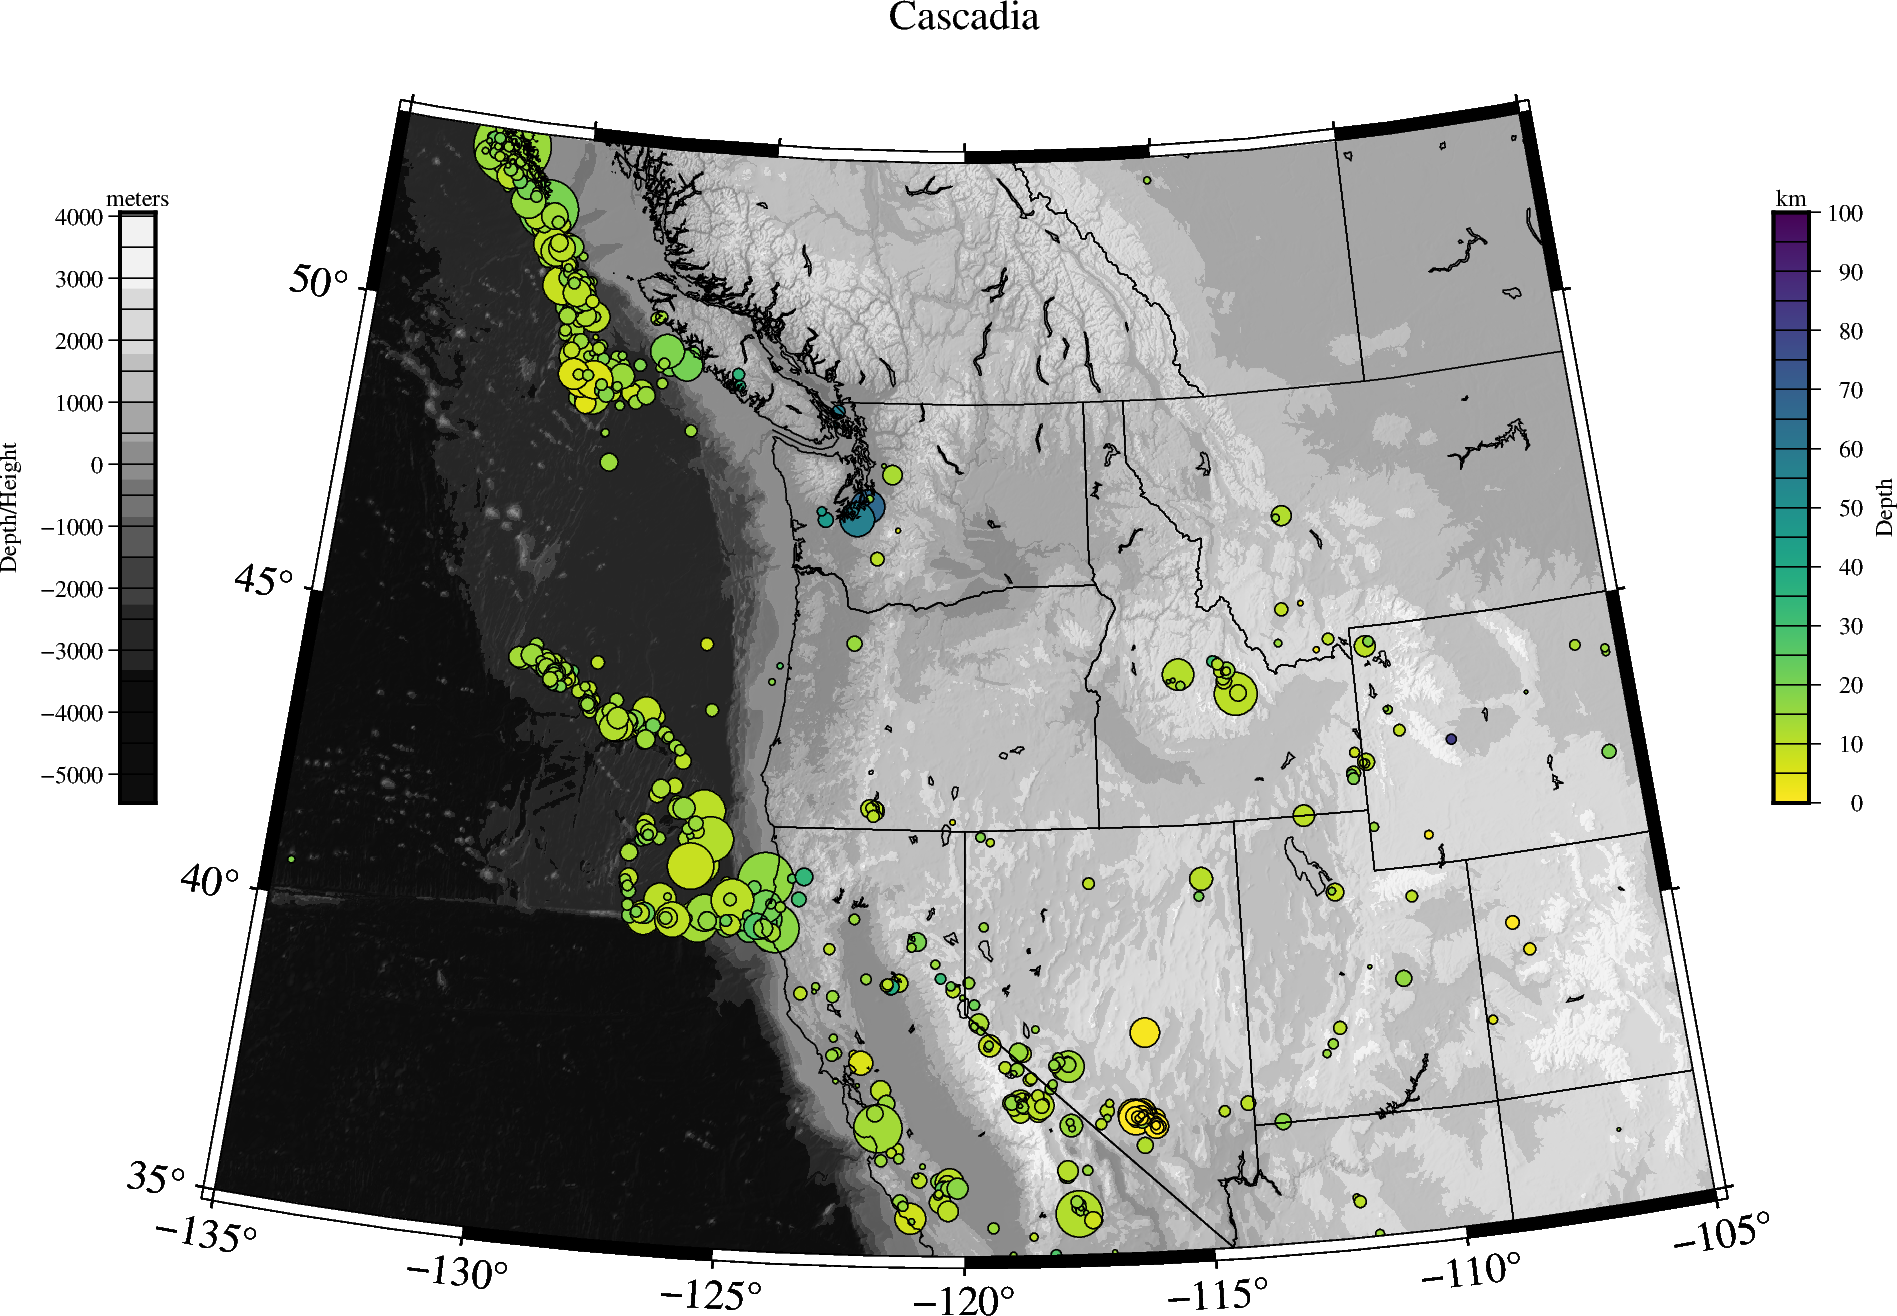

In [14]:
# add earthquakes
dmin = np.floor(iscehb_gdf.Depth.max()/100)*100
dmax = np.ceil(iscehb_gdf.Depth.max()/100)*100

print(dmin,dmax)

pygmt.makecpt(cmap="viridis", series=[dmin,dmax],reverse=True)

fig.plot(x=iscehb_gdf.geometry.x,
         y=iscehb_gdf.geometry.y,
         size=0.003 * (2**iscehb_gdf.Magnitude),
         style="cc",
         fill=iscehb_gdf.Depth,
         cmap=True,
         pen="black")

fig.colorbar(position="JMR+o0.5c/1.5c+w5c/0.3c", box=False,
             frame=["a10g5","x+lDepth", "y+lkm"])

fig.coast(region=region_data,
          frame=["a", "+tCascadia"],
          shorelines=True,
          borders=[1,2,3],
          projection=proj1)

fig.show()